<h1> Important imports </h1>

In [ ]:
! pip install tf_explain
! pip install keras_preprocessing

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c state-farm-distracted-driver-detection

state-farm-distracted-driver-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip state-farm-distracted-driver-detection

Archive:  state-farm-distracted-driver-detection.zip
replace driver_imgs_list.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 #opencv library
import glob
import matplotlib.pyplot as plt  #plotting library
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import random
from skimage import io
from keras.callbacks import EarlyStopping
from PIL import Image
from tqdm import tqdm
import h5py
import seaborn as sns
import os
import random as rnd
import secrets
import plotly.express as px
from tf_explain.core.activations import ExtractActivations
from tf_explain.core.grad_cam import GradCAM
from tensorflow.keras.layers import Input, Conv2D,GlobalAveragePooling2D , MaxPooling2D, AveragePooling2D, Concatenate, Flatten, Dense
from tensorflow.keras.applications import ResNet50
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential, Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import img_to_array, load_img
from keras.layers import Convolution2D,Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
print(os.listdir("/content/imgs"))

['train', 'test']


<h1> Setting directory paths </h1>

In [ ]:
df_train_full = pd.read_csv('/content/driver_imgs_list.csv')
df_train_full['path']= '/content/imgs/train/' + df_train_full['classname']+ '/' +df_train_full['img']
df_test = '/content/imgs/'
train_dir='/content/imgs/train/'

In [ ]:
classes = {   'c0' : "safe_driving",
                      'c1' : "texting-right",
                      'c2' : "talking_on_the_phone-right",
                      'c3' : "texting-left",
                      'c4' : "talking_on_the_phone-left",
                      'c5' : "operating_the_radio",
                      'c6' : "drinking",
                      'c7' : "reaching_behind",
                      'c8' : "hair-and-makeup",
                      'c9' : "talking_to_passenger"}
classes

{'c0': 'safe_driving',
 'c1': 'texting-right',
 'c2': 'talking_on_the_phone-right',
 'c3': 'texting-left',
 'c4': 'talking_on_the_phone-left',
 'c5': 'operating_the_radio',
 'c6': 'drinking',
 'c7': 'reaching_behind',
 'c8': 'hair-and-makeup',
 'c9': 'talking_to_passenger'}

In [ ]:
df_train_full.head()

,subject,classname,img,path
0,p002,c0,img_44733.jpg,/content/imgs/train/c0/img_44733.jpg
1,p002,c0,img_72999.jpg,/content/imgs/train/c0/img_72999.jpg
2,p002,c0,img_25094.jpg,/content/imgs/train/c0/img_25094.jpg
3,p002,c0,img_69092.jpg,/content/imgs/train/c0/img_69092.jpg
4,p002,c0,img_92629.jpg,/content/imgs/train/c0/img_92629.jpg


In [ ]:
num_samples_to_use = int(0.25 * len(df_train_full))
subset_indices = random.sample(range(len(df_train_full)), num_samples_to_use)
df_train = df_train_full.iloc[subset_indices]

# Print the number of samples in the 25% subset
print("Number of samples in 25% subset:", len(df_train))

Number of samples in 25% subset: 5606


In [ ]:
print("Number of image files for in training dataset: ",len(df_train))
print("Number of classes: ",len(df_train['classname'].value_counts()))

Number of image files for in training dataset:  5606
Number of classes:  10


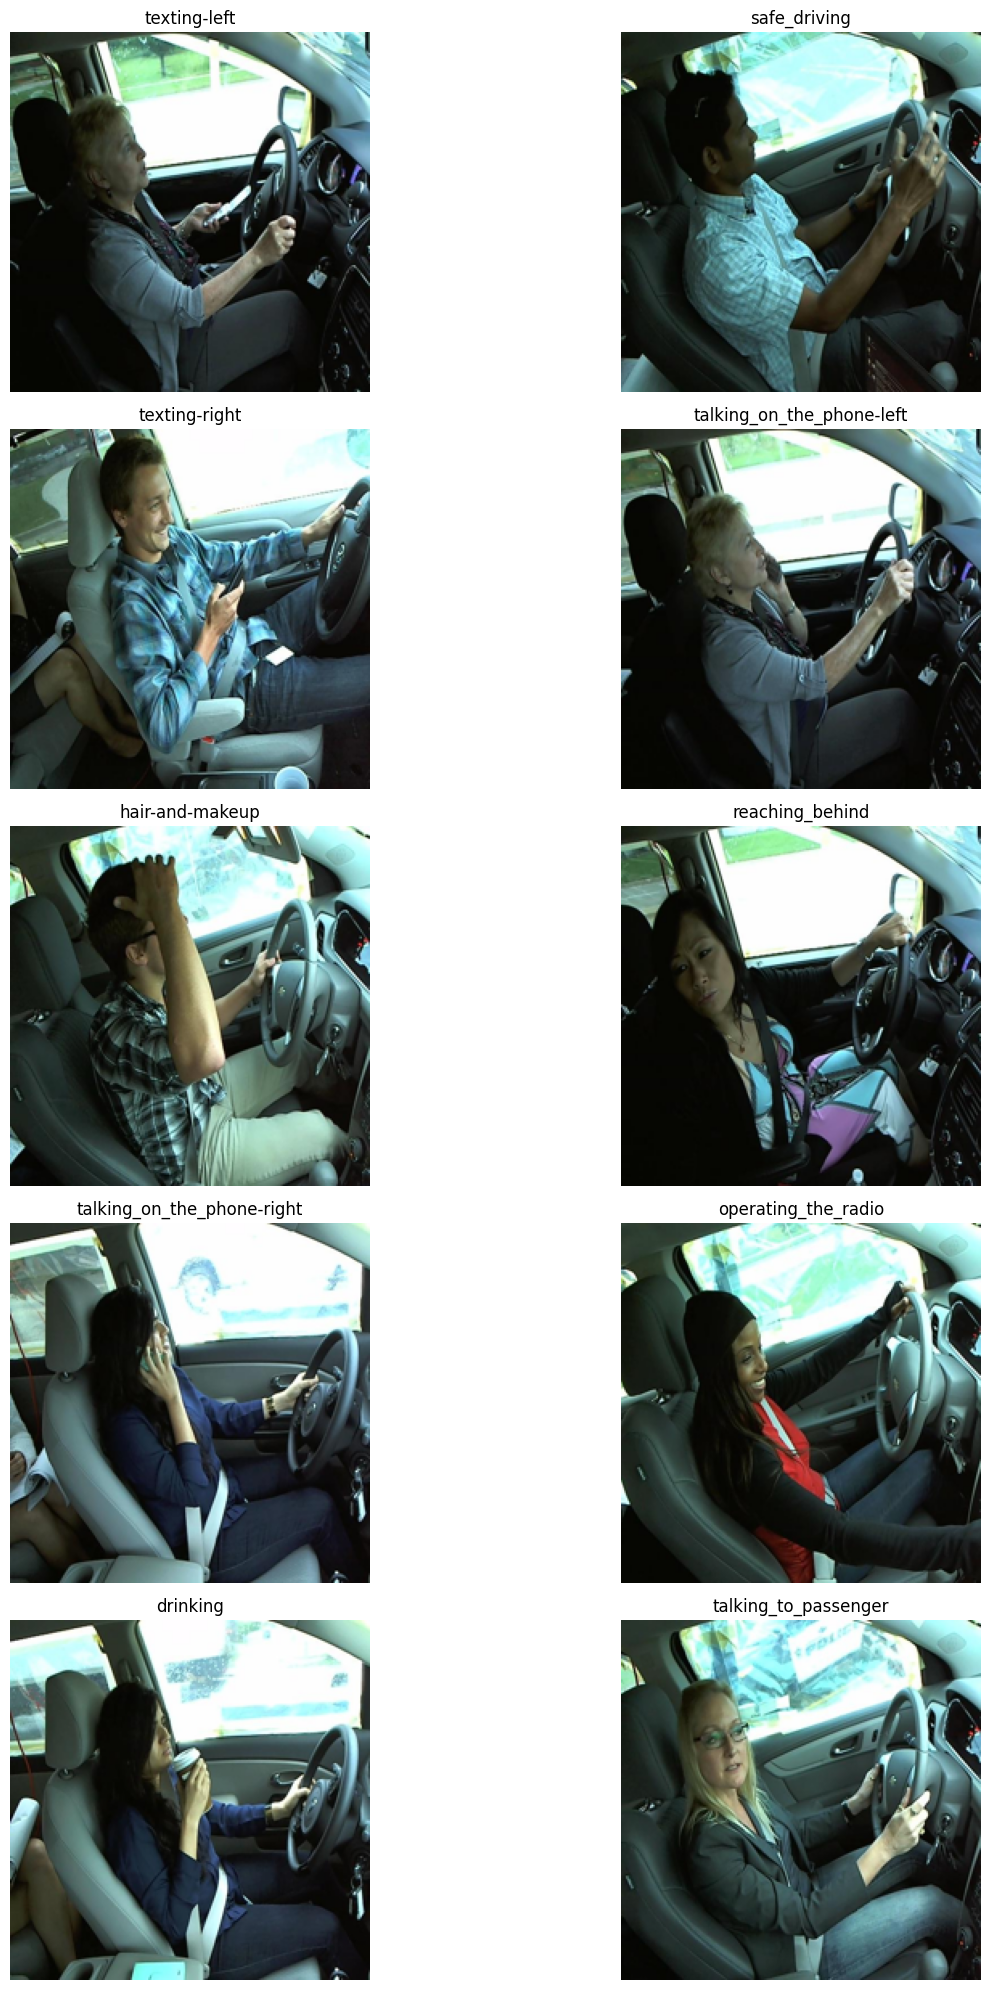

In [ ]:
plt.figure(figsize = (15,20))
for idx,i in enumerate(df_train.classname.unique()):
    plt.subplot(5,2,idx+1)
    df = df_train[df_train['classname'] ==i].reset_index(drop = True)
    image_path = df.loc[rnd.randint(0, len(df))-1,'path']
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(classes[i])
plt.tight_layout()
plt.show()

In [ ]:
# Create the count plot
fig = px.histogram(df_train, x='classname', color_discrete_sequence=['blue'])  # Change the color here

# Set the layout
fig.update_layout(
    title='Driver Class Distribution',
    title_font=dict(family='Arial', size=24),  # Change the font family and size for the title
    xaxis_title='Driver classes',
    xaxis=dict(title_font=dict(family='Arial', size=18)),  # Change the font family and size for x-axis label
    yaxis_title='Count',
    yaxis=dict(title_font=dict(family='Arial', size=14)),  # Change the font family and size for y-axis label
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=50, r=50, t=100, b=50),
)



# Show the plot
fig.show()

In [ ]:
widths, heights = [], []

for path in tqdm(df_train["path"]):
    width, height = Image.open(path).size
    widths.append(width)
    heights.append(height)

df_train["width"] = widths
df_train["height"] = heights
df_train["dimension"] = df_train["width"] * df_train["height"]

100%|██████████| 5606/5606 [00:00<00:00, 14103.62it/s]
<ipython-input-15-45a28a193c6a>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-45a28a193c6a>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-45a28a193c6a>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [ ]:
df_train

,subject,classname,img,path,width,height,dimension
18840,p064,c3,img_42286.jpg,/content/imgs/train/c3/img_42286.jpg,640,480,307200
1570,p014,c0,img_13916.jpg,/content/imgs/train/c0/img_13916.jpg,640,480,307200
4422,p021,c0,img_76198.jpg,/content/imgs/train/c0/img_76198.jpg,640,480,307200
8256,p026,c1,img_26950.jpg,/content/imgs/train/c1/img_26950.jpg,640,480,307200
8148,p026,c0,img_87270.jpg,/content/imgs/train/c0/img_87270.jpg,640,480,307200
...,...,...,...,...,...,...,...
11973,p045,c0,img_89574.jpg,/content/imgs/train/c0/img_89574.jpg,640,480,307200
5058,p021,c5,img_86048.jpg,/content/imgs/train/c5/img_86048.jpg,640,480,307200
17091,p056,c1,img_3205.jpg,/content/imgs/train/c1/img_3205.jpg,640,480,307200
7023,p024,c1,img_51655.jpg,/content/imgs/train/c1/img_51655.jpg,640,480,307200


<h1> Create training / test data </h1>

**Augmentation**


In [ ]:
def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def change_contrast(img, level):
    img = Image.fromarray(img.astype('uint8'))
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return np.array(img.point(contrast))

def preprocessing(img):
    img_arr = np.array(img)

    x = random.randint(0, 1)

    if x == 0:
        img_arr = increase_brightness(img_arr, secrets.randbelow(26))
        img_arr = change_contrast(img_arr, secrets.randbelow(51))
    else:
        img_arr = change_contrast(img_arr, secrets.randbelow(51))
        img_arr = increase_brightness(img_arr, secrets.randbelow(26))

    return img_arr


datagen = ImageDataGenerator(
        rotation_range = 5,
        width_shift_range = 0.03,
        height_shift_range = 0.03,
        shear_range = 0.03,
        zoom_range = 0.03,
        horizontal_flip = False,
        fill_mode = "nearest",
        validation_split = 0.2,
        preprocessing_function = preprocessing)

In [ ]:
X, y = df_train[['path', 'classname']], df_train['classname']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
dict_class = {'c0':0, 'c1':1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5':5, 'c6': 6, 'c7':7, 'c8':8, 'c9':9}

In [ ]:
def gradcam_visualise(data, model, class_index):
    explainer = GradCAM()
    output = explainer.explain(data, model, class_index=class_index)
    return output

def activation_visualise(image, model, layers):
    explainer = ExtractActivations()
    output = explainer.explain([image], model, layers_name=layers)
    return output

In [ ]:
def plot_data_four(class_name, outputs):
    fig = plt.figure(figsize=(16, 16))
    plt.suptitle(classes[class_name])
    plt.subplot(2,2,1)
    plt.imshow(outputs[0])
    plt.subplot(2,2,2)
    plt.imshow(outputs[1])
    plt.subplot(2,2,3)
    plt.imshow(outputs[2])
    plt.subplot(2,2,4)
    plt.imshow(outputs[3])
    plt.show()

In [ ]:
def grad_cam(model, df_exp, class_name, class_index, image_size):
    output_data = []
    classes_df = df_exp[df_exp['classname'] ==  class_name].reset_index(drop = True)
    for idx,i in enumerate(np.random.choice(classes_df['path'],4)):
        image = cv2.imread(i)
        image = cv2.resize(image, image_size)
        data = ([image], None)
        output = gradcam_visualise(data, model, class_index)
        output_data.append(output)
    plot_data_four(class_name, output_data)

In [ ]:
def activations_model(model, df_exp, class_name, layers, image_size):
    output_data = []
    classes_df = df_exp[df_exp['classname'] ==  class_name].reset_index(drop = True)
    for idx,i in enumerate(np.random.choice(classes_df['path'],4)):
        image = cv2.imread(i)
        image = cv2.resize(image, image_size)
        image = tf.expand_dims(image, axis=0)
        output = activation_visualise([image], model, layers)
        output_data.append(output)
    plot_data_four(class_name, output_data)

In [ ]:
#for class_name in X_test['classname'].unique():
   # grad_cam(model, X_test, class_name, dict_class[class_name], (240,240))

In [ ]:
#test_loss, test_accuracy = model.evaluate(validationGenerator_cnn, verbose=1)

# Print the test accuracy
#print("Test Accuracy:", test_accuracy)

In [ ]:
y_count=len(df_train['classname'].unique())
y_count

10

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Parameters
batch_size = 32
image_size = (224, 224)  # Input size expected by EfficientNetB0
num_classes = 10  # Number of classes in your dataset

# Load the EfficientNetB0 model with pre-trained weights from TensorFlow Hub
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(*image_size, 3))

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split the data into training and validation sets
)

train_generator = datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='classname',
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=False,

)

validation_generator = datagen.flow_from_dataframe(
        X_test,  # This is the source directory for training images
        x_col='path',
        y_col='classname',
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=False,
)


# Train the model
model.fit(train_generator, validation_data=validation_generator, epochs=4)


16705208/16705208 [==============================] - 0s 0us/step
Found 3924 validated image filenames belonging to 10 classes.
Found 1682 validated image filenames belonging to 10 classes.
Epoch 1/4
123/123 [==============================] - 147s 756ms/step - loss: 0.5758 - accuracy: 0.8196 - val_loss: 0.7463 - val_accuracy: 0.8650
Epoch 2/4
123/123 [==============================] - 90s 729ms/step - loss: 0.1421 - accuracy: 0.9582 - val_loss: 0.1818 - val_accuracy: 0.9542
Epoch 3/4
123/123 [==============================] - 89s 727ms/step - loss: 0.0961 - accuracy: 0.9722 - val_loss: 0.1690 - val_accuracy: 0.9578
Epoch 4/4
123/123 [==============================] - 89s 723ms/step - loss: 0.0739 - accuracy: 0.9783 - val_loss: 0.1347 - val_accuracy: 0.9620


In [ ]:
test_gen = ImageDataGenerator()
test_data = test_gen.flow_from_directory(df_test ,
                                        target_size=(224,224),
                                        batch_size=32,
                                        classes = ['test'],
                                        shuffle = False)

Found 79726 images belonging to 1 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

2492/2492 [==============================] - 261s 105ms/step - loss: 135.6791 - accuracy: 0.1333
Test Accuracy: 0.1332940310239792


In [ ]:
preds = model.predict(test_data)
preds

2492/2492 [==============================] - 274s 109ms/step


array([[8.46295762e-08, 4.49740369e-08, 6.71941848e-07, ...,
        8.91756144e-07, 3.52493153e-05, 1.01643856e-07],
       [1.49766900e-11, 1.85949381e-11, 3.14673183e-11, ...,
        2.96766188e-11, 3.77564063e-10, 6.44508915e-13],
       [9.87222493e-01, 1.51081971e-04, 8.12266007e-05, ...,
        1.96711175e-04, 2.51009304e-04, 1.00375721e-02],
       ...,
       [1.66210882e-11, 5.05774018e-08, 7.82183818e-10, ...,
        2.43047292e-12, 3.36568746e-08, 1.26261793e-10],
       [5.88461294e-11, 1.78061166e-09, 1.89074548e-10, ...,
        5.05602574e-11, 1.27265498e-09, 4.72211212e-14],
       [1.55334999e-06, 2.26462866e-08, 1.05547677e-08, ...,
        6.28765084e-09, 1.85034594e-07, 5.19263121e-09]], dtype=float32)

In [ ]:
test_imgs = os.path.join(df_test , 'test')
test_ids = sorted(os.listdir(test_imgs))
pred_df = pd.DataFrame(columns=['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
for i in range(len(preds)):
    pred_df.loc[i,'img'] = test_ids[i]
    pred_df.loc[i , 'c0':'c9'] = preds[i]

pred_df

KeyboardInterrupt: ignored

In [ ]:
copy_df=pred_df

# Convert confidence score columns to numeric data type
confidence_cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
copy_df[confidence_cols] = copy_df[confidence_cols].apply(pd.to_numeric)

# Randomly select 10 indices
random_indices = random.sample(range(len(copy_df)), 10)

# Load and display randomly selected images with predicted class labels
for index in random_indices:
    row = copy_df.iloc[index]
    img_path = row['img']
    predicted_class = classes[confidence_cols[row[confidence_cols].values.argmax()]]

    img = Image.open(df_test+'test/'+img_path)

    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

In [ ]:
pred_df.to_csv('submission.csv',index = False)

In [ ]:
img_path

In [ ]:
for class_name in X_test['classname'].unique():
    grad_cam(model, X_test, class_name, dict_class[class_name], (224,224))

In [ ]:
preds_val = model.predict(validation_generator)
predicted_labels = np.argmax(preds_val, axis=1)
true_labels = validation_generator.classes
print(confusion_matrix(true_labels, predicted_labels))
print(classification_report(true_labels, predicted_labels ))

53/53 [==============================] - 33s 617ms/step
[[177   1   0   0   0   0   0   0   1   5]
 [  0 166   0   0   0   0   0   0   0   0]
 [  0   0 174   0   0   0   0   0   5   0]
 [  2   0   0 181   0   0   0   0   0   0]
 [  0   0   0   1 165   0   0   0   1   0]
 [  0   0   0   0   0 173   0   0   0   0]
 [  1   2   0   0   0   0 183   0   0   0]
 [  0   0   0   0   0   0   0 130   2   0]
 [  0   0   0   0   0   0   3   0 155   2]
 [ 14   0   0   0   1   0   0   0  17 120]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       184
           1       0.98      1.00      0.99       166
           2       1.00      0.97      0.99       179
           3       0.99      0.99      0.99       183
           4       0.99      0.99      0.99       167
           5       1.00      1.00      1.00       173
           6       0.98      0.98      0.98       186
           7       1.00      0.98      0.99       132
           8       0.86   

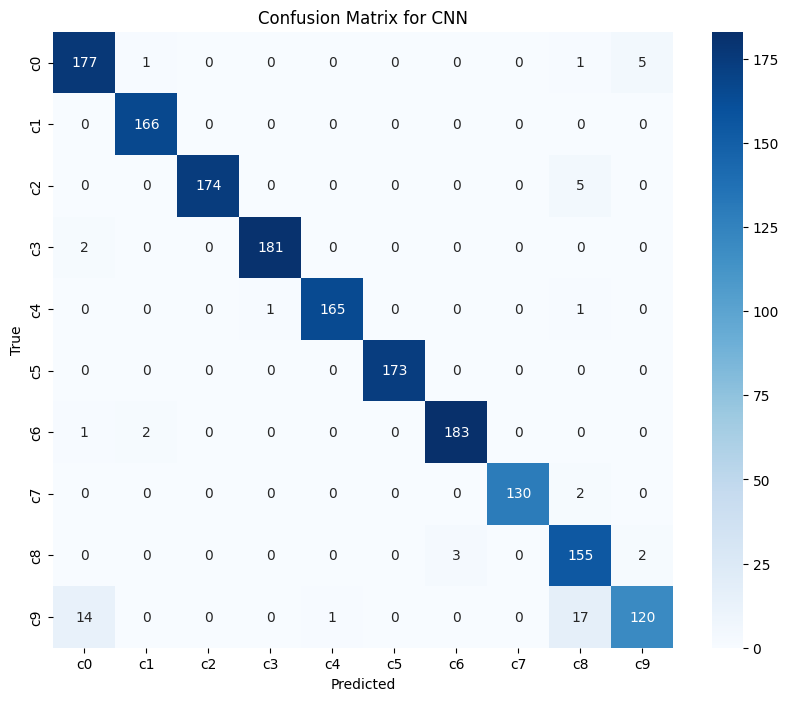

In [ ]:
# Create a heatmap of the confusion matrix
class_names = list(validation_generator.class_indices.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CNN')
plt.show()